# Import Libraries

In [1]:
import sys
sys.path.append("/home/felix/PycharmProjects/Quantum-Challenge/")
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import traceback
import math
import networkx as nx
import itertools
from qiskit.algorithms import AmplificationProblem
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover
from qiskit.circuit.library import GroverOperator
from qiskit.extensions import Initialize
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from itertools import product 
from qiskit.quantum_info import Statevector
import utils.utils as ut
from importlib import reload

# Load flight Data 

In [5]:
flight_df = pd.read_csv("../data/flights.csv", sep=";")

# Load velocity and fuel consumption data

In [6]:
cruise_df = pd.read_pickle("../data/cruise_df.pkl")
climb_df = pd.read_pickle("../data/climb_df.pkl")
descent_df = pd.read_pickle("../data/descent_df.pkl")

# Load climate data

In [81]:
climate_df = pd.read_pickle("../data/climate_df.pkl")

# Quantum Trajectory Optimization

In [8]:
G = nx.read_gpickle("../data/w_graph.pkl")

Each node in the graph has a set of edges whose weight is the climate cost of traveling from one voxel center to another.
As an example, take the node (4,4,4) with the following Edges:

- (3, 4, 4): {'w': 103.63} 
- (4, 3, 4): {'w': 134.84} 
- (5, 4, 4): {'w': 103.67} 
- (4, 5, 4): {'w': 135.80}
- (3, 4, 3): {'w': 112.62}
- (5, 4, 5): {'w': 102.56}

For this specific node, a given aircraft has the option to change the $x$ coordinate by $\pm 2 ^{\circ}$, the $y$ coordinate by $\pm 2 ^{\circ}$, or the $x$ coordinate by $\pm 2 ^{\circ}$ and the $z$ coordinate by $\pm 20 FL$.



Create random paths from the start point to the end point at each altitude and convert them to valid trajectories. This gives a total of $32=2^5$ trajectories for each flight.

In [15]:
rand_traj_arr = []
for s_inx, (_, t, z, x_s, y_s, x_e, y_e) in enumerate(flight_df.to_numpy()):
    rand_traj_i = []
    tuple_path = ut.gen_rand_path(G, x_s, y_s, z, x_e, y_e, size = 2)
    for tup in tuple_path:
        rand_traj_i.append(ut.tuple_path_to_trajec(tup, start_index=s_inx) ) 
    rand_traj_arr.append(rand_traj_i)
# np.save("../data/rand_traj_arr.npy",np.array(rand_traj_arr,dtype=object))

0
10
20
30
40
50
60
70
80
90


In [38]:
rand_traj_arr = np.load("../data/rand_traj_arr.npy", allow_pickle=True)

For each set of possible trajectories of a flight, assign a calculation base state to be used in the Grovers search. The assignment is stored in the basis_state_to_trajec dictionary.

In [82]:
basis_state_to_trajec

{'00000': [{'x': -30.0,
   'y': 40.0,
   'z': 280,
   't': numpy.datetime64('2018-06-23T07:55:00'),
   'delta_t': numpy.timedelta64(0,'s')},
  {'x': -28.0,
   'y': 40.0,
   'z': 300,
   't': numpy.datetime64('2018-06-23T08:07:00'),
   'delta_t': numpy.timedelta64(720,'s')},
  {'x': -26.0,
   'y': 40.0,
   'z': 320,
   't': numpy.datetime64('2018-06-23T08:19:05'),
   'delta_t': numpy.timedelta64(725,'s')},
  {'x': -24.0,
   'y': 40.0,
   'z': 320,
   't': numpy.datetime64('2018-06-23T08:31:11'),
   'delta_t': numpy.timedelta64(726,'s')},
  {'x': -22.0,
   'y': 40.0,
   'z': 320,
   't': numpy.datetime64('2018-06-23T08:43:17'),
   'delta_t': numpy.timedelta64(726,'s')},
  {'x': -20.0,
   'y': 40.0,
   'z': 320,
   't': numpy.datetime64('2018-06-23T08:55:23'),
   'delta_t': numpy.timedelta64(726,'s')},
  {'x': -18.0,
   'y': 40.0,
   'z': 320,
   't': numpy.datetime64('2018-06-23T09:07:29'),
   'delta_t': numpy.timedelta64(726,'s')},
  {'x': -16.0,
   'y': 40.0,
   'z': 320,
   't': numpy

For each set of basis states, perform a Grovers search using the find_min_cost_quantum function to find the state corresponding to the trajectory with the lowest climate impact.

In [19]:
n_qubits = 5
lst = list(itertools.product([0, 1], repeat=n_qubits))
final_traj_arr = []

for cnt_1 in range(len(rand_traj_arr)):
    basis_state_to_trajec = {}
    for cnt_2, b_state in enumerate(lst):
        try:
            basis_state_to_trajec[ut.convert_tuple(b_state)] = rand_traj_arr[cnt_1][cnt_2]
        except:
            basis_state_to_trajec[ut.convert_tuple(b_state)] = rand_traj_arr[cnt_1][0]
        
    state_arr = np.array([ut.convert_tuple(l) for l in lst])
    
    final_traj_arr.append(ut.find_min_cost_quantum(state_arr, basis_state_to_trajec,False))          
# np.save("../data/final_traj_arr.npy",np.array(final_traj_arr,dtype=object))

0
10
20
30
40
50
60
70
80
90


In [24]:
final_traj_arr_t = np.load("../data/final_traj_arr.npy",allow_pickle=True)

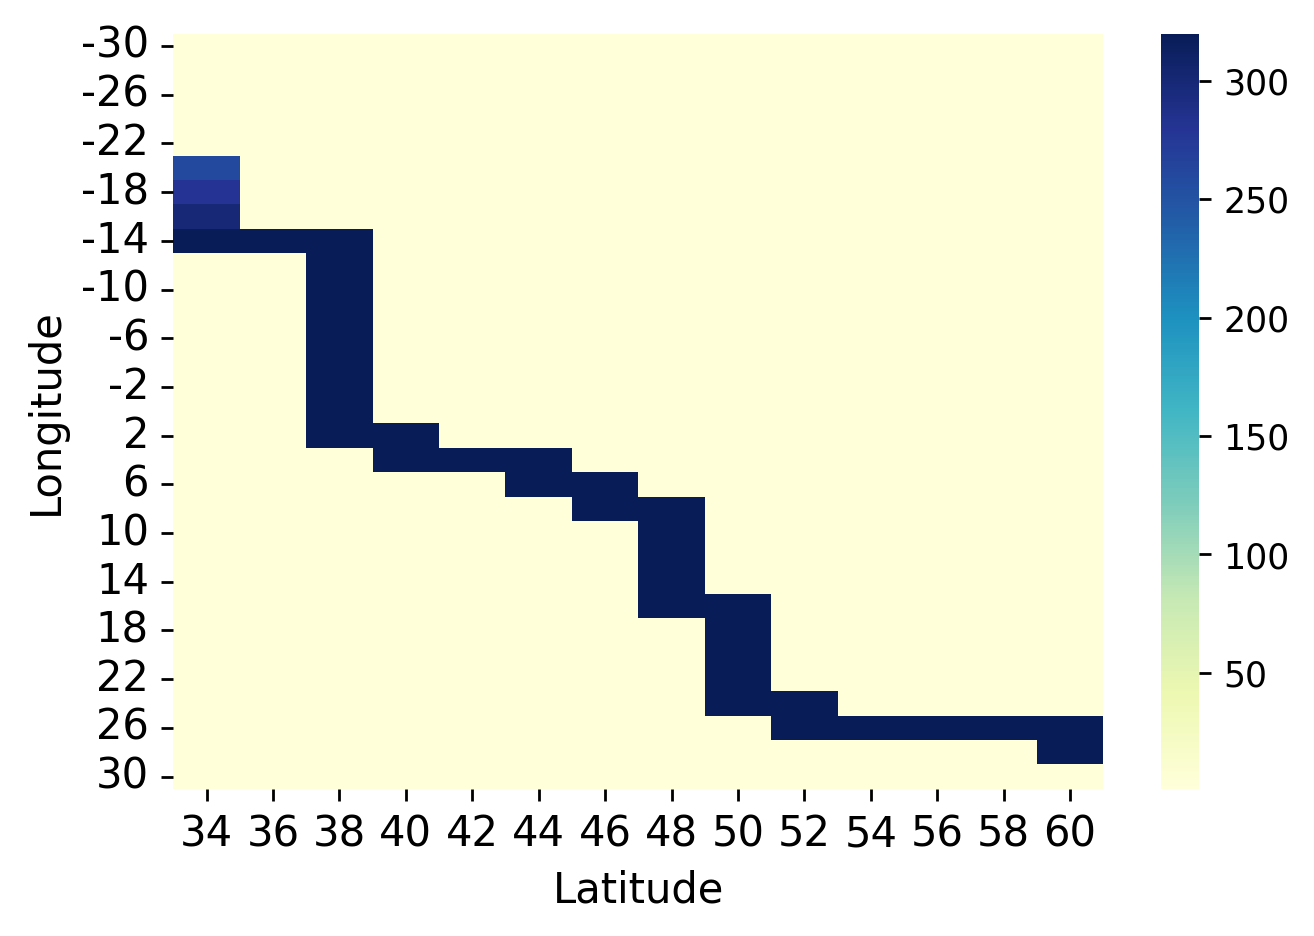

In [97]:
test_q_traj = final_traj_arr_t[11][1]
box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))

for c_1, i in enumerate(x_arr):
    for c_2, j in enumerate(y_arr):
        box_2d[c_1][c_2] = 1
        for c_3, l in enumerate(test_q_traj):
            if i == l["x"] and j == l["y"]:
                box_2d[c_1][c_2] = l["z"]#
                
fig, ax = plt.subplots(dpi=250) 
#sns.set(font_scale = 0.5)
ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0, cmap="YlGnBu")
ax.set_ylabel("Longitude")
ax.set_xlabel("Latitude")

    
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)


ax.set_yticks(ax.get_yticks()[::2])
ax.legend
plt.show()

# Compute performance metric of flight schedule

In [84]:
classical_climate_delta_T = np.sum([ut.C(tr) for tr in np.array(final_traj_arr_t,dtype=object)[:,1]])
classical_climate_delta_T

5.6385113547554625e-06

In [87]:
np.sum([ut.consumed_fuel(tr)[0] for tr in np.array(final_traj_arr_t,dtype=object)[:,1]])

1954337.3806987768

In [88]:
np.sum([ut.time_traveled(tr)for tr in np.array(final_traj_arr_t,dtype=object)[:,1]])

numpy.timedelta64(2758654,'s')

# Run on hardware

In [83]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2022-04-25 10:43:17,594: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_santiago


Repeat the search for the trajectory with the lowest climate impact, with the find_min_cost_quantum function now taking the found device as an additional argument and performing the Grovers search on it.

In [59]:
n_qubits = 5
lst = list(itertools.product([0, 1], repeat=n_qubits))
final_traj_arr = []

for cnt_1 in range(len(rand_traj_arr)):
    basis_state_to_trajec = {}
    for cnt_2, b_state in enumerate(lst):
        try:
            basis_state_to_trajec[ut.convert_tuple(b_state)] = rand_traj_arr[cnt_1][cnt_2]
        except:
            basis_state_to_trajec[ut.convert_tuple(b_state)] = rand_traj_arr[cnt_1][0]
        
    state_arr = np.array([ut.convert_tuple(l) for l in lst])
    
    final_traj_arr.append(ut.find_min_cost_quantum(state_arr, basis_state_to_trajec, True, device))
    
    if cnt_1 == 10 :
        break

/home/felix/anaconda3/envs/vae-wavefunctions/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:695: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)


In [68]:
# np.save("../data/res_q_sim.npy",np.array(res_q_sim,dtype=object))

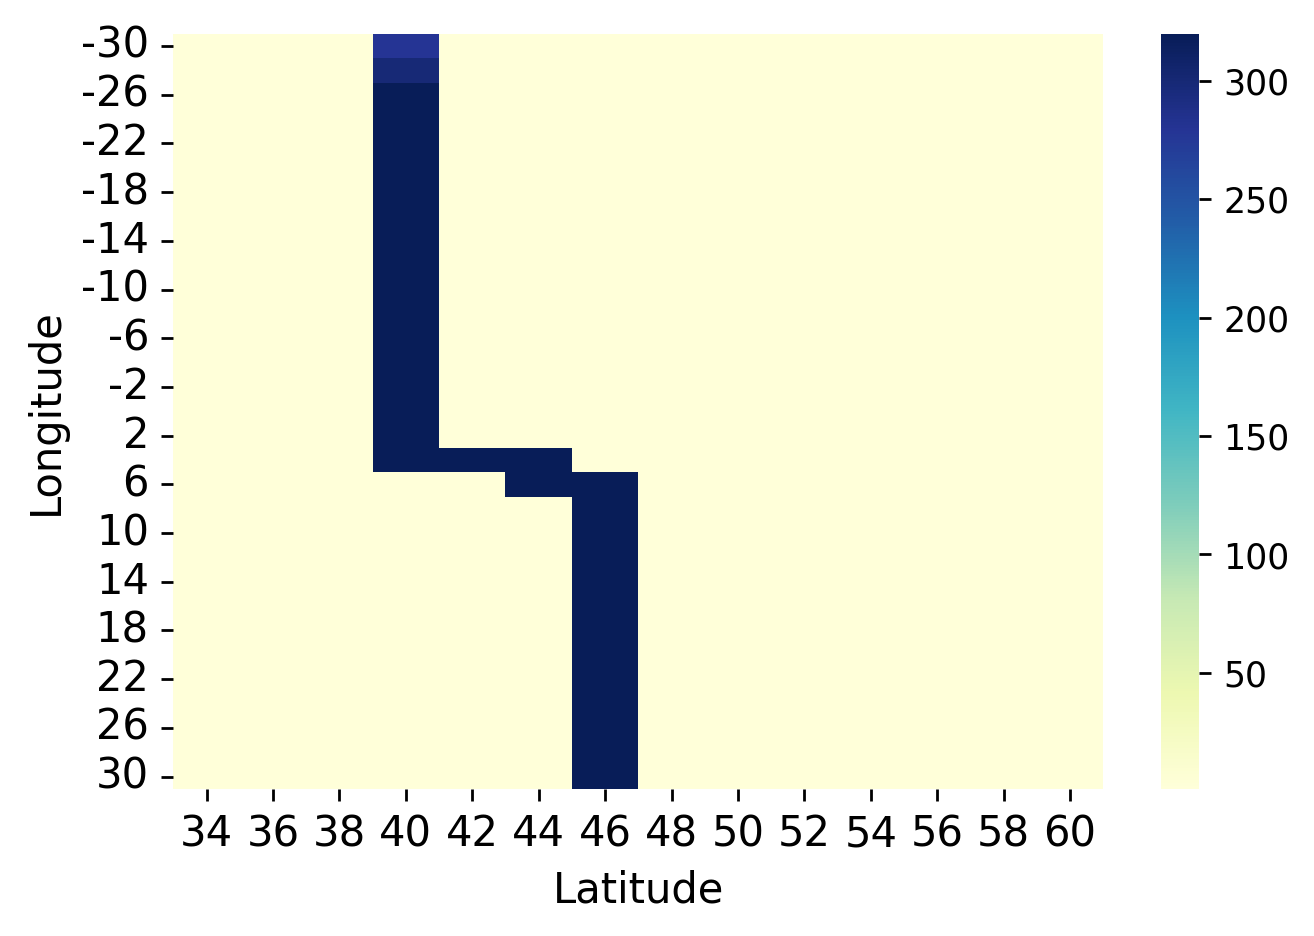

In [102]:
test_q_traj = final_traj_arr[10][1]
box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))

for c_1, i in enumerate(x_arr):
    for c_2, j in enumerate(y_arr):
        box_2d[c_1][c_2] = 1
        for c_3, l in enumerate(test_q_traj):
            if i == l["x"] and j == l["y"]:
                box_2d[c_1][c_2] = l["z"]#
                
fig, ax = plt.subplots(dpi=250) 
ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0, cmap="YlGnBu")
ax.set_ylabel("Longitude")
ax.set_xlabel("Latitude")
  
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

ax.set_yticks(ax.get_yticks()[::2])
ax.legend
plt.show()

# Compute performance metric of flight schedule

In [71]:
classical_climate_delta_T = np.sum([ut.C(tr) for tr in np.array(final_traj_arr,dtype=object)[:,1]])
classical_climate_delta_T

5.967020006194978e-07

In [79]:
np.sum([ut.consumed_fuel(tr)[0] for tr in np.array(final_traj_arr,dtype=object)[:,1]])

2104850.8664146

In [77]:
np.sum([ut.time_traveled(tr)for tr in np.array(final_traj_arr,dtype=object)[:,1]])

numpy.timedelta64(49250,'s')

# Circuit plot

In [89]:
# plot_x = [ temp["x"]  for temp in  basis_state_to_trajec['10010'] ]
# plot_y = [ temp["y"]  for temp in  basis_state_to_trajec['10010'] ]
# plot_z = [ temp["z"]  for temp in  basis_state_to_trajec['10010'] ]
# # %matplotlib notebook
# flight_dict = flight_df.to_dict()
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# ax.set_zlabel("Flightlevel")
# ax.plot(plot_x, plot_y, plot_z,color="#003153",mec='black', marker="o", ms=8)
# plt.show()

In [193]:
# x_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 200) & (climate_df["TIME"] == "2018-06-23 06:00:00"), "LONGITUDE"].to_numpy()
# y_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 200) & (climate_df["TIME"] == "2018-06-23 06:00:00"), "LATITUDE"].to_numpy()
# merged_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 200) & (climate_df["TIME"] == "2018-06-23 06:00:00"), "MERGED"].to_numpy()

In [844]:
# fig, ax = plt.subplots(dpi=150)


# ax.plot(fl, tas, label= "TAS [kts]",color="#003153", mec="black", marker="o", ms=8)#[[0,0.1922,0.3255]]


# ax2 = ax.twinx()


# ax2.plot(fl, fuel, label="Fuel [kg/min]",color="#A42A04", mec='black', marker="o", ms=8)    


# ax2.invert_yaxis()

# ax.set_xlabel("Flight Level", fontsize=12)
# ax2.set_ylabel("Fuel Consumption rate",fontsize=12)
# ax.set_ylabel("True Air Speed",fontsize=12)

# fig.legend(bbox_to_anchor=(0.65, 0.88), loc=2)

In [ ]:
# #%matplotlib notebook
# flight_dict = flight_df.to_dict()

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# x_s = np.fromiter(flight_dict["start_longitudinal"].values(), dtype=float)
# y_s = np.fromiter(flight_dict["start_latitudinal"].values(), dtype=float)
# z_s = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)

# x_e = np.fromiter(flight_dict["end_longitudinal"].values(), dtype=float)
# y_e = np.fromiter(flight_dict["end_latitudinal"].values(), dtype=float)
# z_e = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)


# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# ax.set_zlabel("Flightlevel")

# ax.scatter(x_s, y_s, z_s,c="#003153")
# ax.scatter(x_e, y_e, z_e, c="#A42A04")

# #ax.invert_zaxis()

# plt.show()

In [ ]:
# max_x = 30 
# min_x = -30 

# max_y = 60  
# min_y = 34  

# spacing_xy = 2

# max_z = 400
# min_z = 100
# spacing_z = 20
# x_arr = np.arange(min_x, max_x + spacing_xy, spacing_xy)
# y_arr = np.arange(min_y, max_y + spacing_xy, spacing_xy)
# z_arr = np.arange(min_z, max_z + spacing_z, spacing_z)